## Global and Local Explanations

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss


## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import shap
shap.initjs()

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

import warnings
warnings.filterwarnings("ignore")
import joblib, os

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

### Loading Data

In [3]:
# Load the joblib file stored in the models folder
fname = 'Models/Best-Models.joblib'
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [4]:
# Saving the loaded objects as separate variables
X_train = loaded['X_train']
y_train = loaded['y_train']
X_test = loaded['X_test']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg= loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

## Global Explanations:

In [5]:
preprocessor.fit(X_train)

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns=preprocessor.get_feature_names_out(),
                          index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns=preprocessor.get_feature_names_out(),
                        index=X_test.index)
display(X_train_df)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
8269,7.220000,0.064142,61.2510,1998.0,1.0,2.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7604,6.135000,0.079294,111.2860,2009.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2762,12.150000,0.028593,151.0708,2004.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6464,5.945000,0.093009,127.8652,2004.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4707,18.200000,0.066285,247.2092,2004.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,12.822634,0.012216,162.7894,1985.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8360,11.500000,0.014884,174.5080,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5929,5.110000,0.034945,161.1210,2002.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4220,6.550000,0.034800,157.5288,2007.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
X_shap = shap.sample(X_train_df, 100)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
5237,16.000,0.060971,226.2404,2002.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
6294,7.825,0.079614,65.0826,2004.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6845,15.200,0.021240,216.9824,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4890,10.000,0.067482,234.8590,2009.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5038,17.500,0.015585,185.1266,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [7]:
rf_explainer = shap.Explainer(rf_reg)  

rf_shap_values = rf_explainer(X_shap)

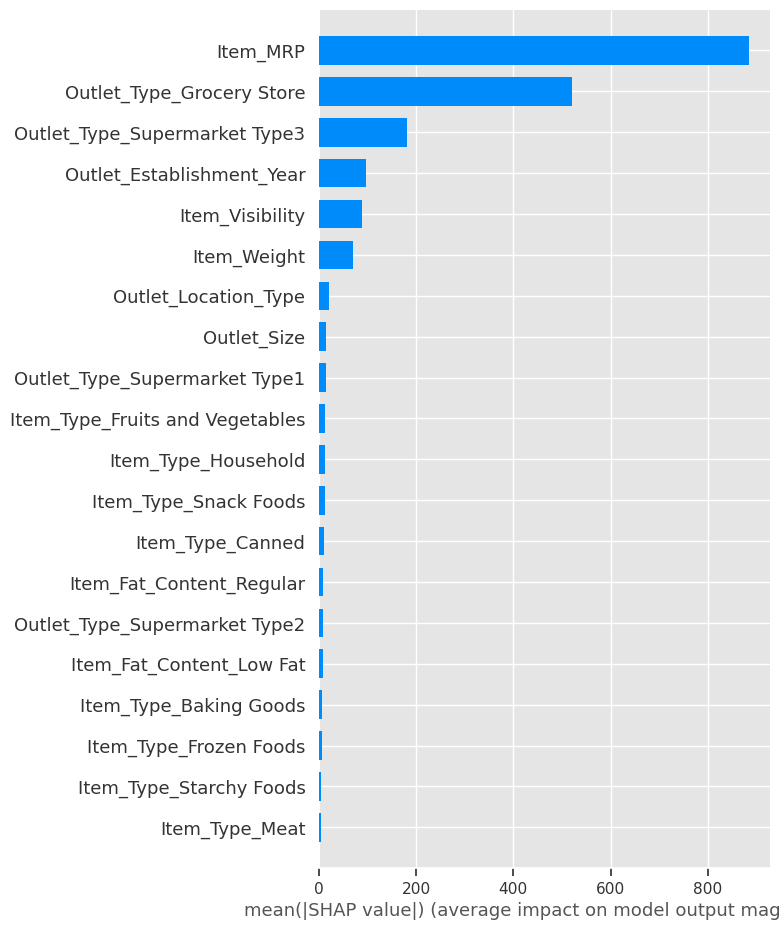

In [8]:
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='bar')

**SHAP vs. your original feature importances**

- The features with the same rank are Item_MRP and Outlet_Type_Grocery Store. The only third feature in this model is Outlet_Type_Supermarket Type 3 and in the feature importance model, it was Item_Visibility. 

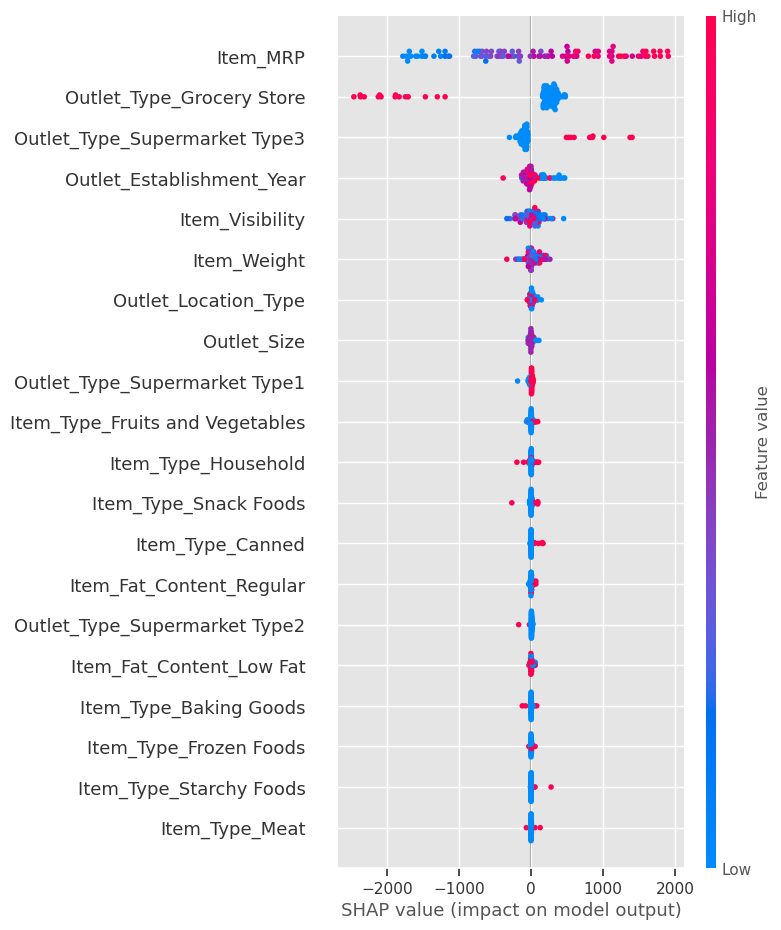

In [9]:
shap.summary_plot(rf_shap_values, features = X_shap, plot_type='dot')

- The Item_MRP is the most impactful feature, suggesting a prediction of more sales in relation to the Item_MRP. 
- The Outlet_Type_Grocery Store has a negative distribution in the plot. Suggesting this type of outlet impacts the sales negatively. 
- The Outlet_Type_Supermarket Type 3 skews more towards a positive prediction of sales if the outlet is a type 3.  

## Local Explanations

In [10]:
rf_explainer = shap.Explainer(rf_reg)
rf_shap_values = rf_explainer(X_shap)

rf_explainer

In [11]:
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,...,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,16.000,0.060971,226.2404,2002.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,7.825,0.079614,65.0826,2004.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,15.200,0.021240,216.9824,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,10.000,0.067482,234.8590,2009.0,1.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,17.500,0.015585,185.1266,1999.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [15]:
X_shap_local['Item_Visibility'].describe()

count    100.000000
mean       0.064722
std        0.052554
min        0.000000
25%        0.024792
50%        0.051887
75%        0.096814
max        0.311090
Name: Item_Visibility, dtype: float64

In [16]:
X_shap_local['Item_MRP'].describe()

count    100.000000
mean     139.316360
std       61.733521
min       32.921600
25%       96.433100
50%      137.389000
75%      186.455600
max      256.164600
Name: Item_MRP, dtype: float64

In [13]:
shap_values = rf_explainer(X_shap_local,y_shap_local)
shap_vals_1 = shap_values[:]

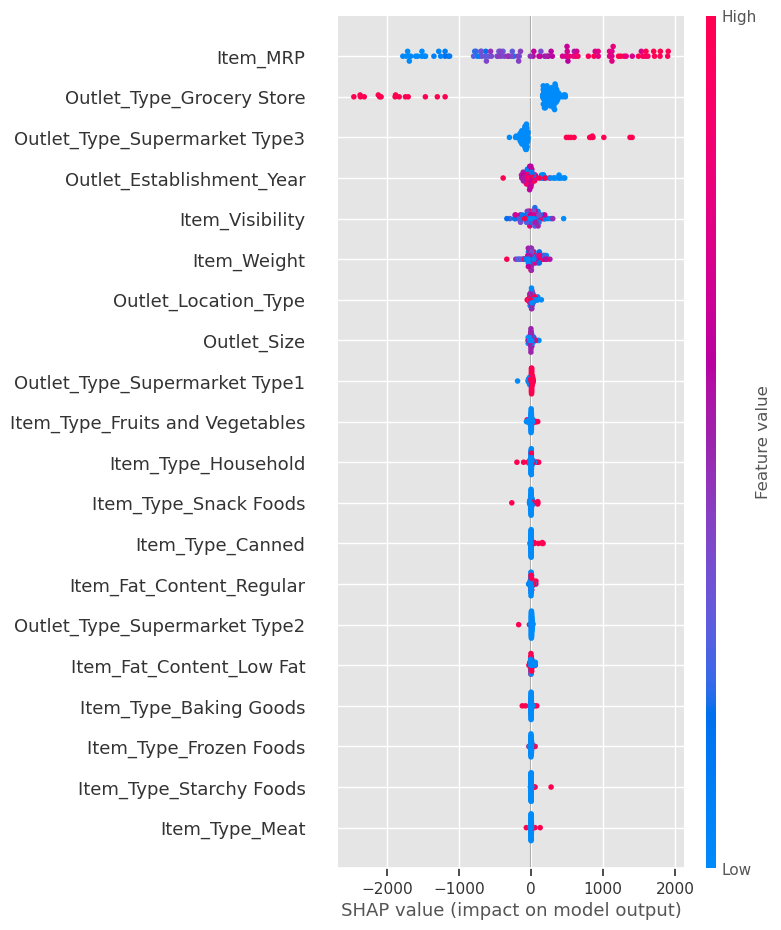

In [14]:
shap.summary_plot(shap_vals_1,X_shap_local)

## Low Sales

In [17]:
idx_low_sales = y_shap_local.idxmin()
idx_low_sales

66

In [19]:
X_shap_local.iloc[idx_low_sales]

Item_Weight                          16.70000
Item_Visibility                       0.10385
Item_MRP                             58.85620
Outlet_Establishment_Year          1998.00000
Outlet_Size                           1.00000
Outlet_Location_Type                  2.00000
Item_Fat_Content_Low Fat              0.00000
Item_Fat_Content_Regular              1.00000
Item_Type_Baking Goods                0.00000
Item_Type_Breads                      0.00000
Item_Type_Breakfast                   0.00000
Item_Type_Canned                      0.00000
Item_Type_Dairy                       0.00000
Item_Type_Frozen Foods                0.00000
Item_Type_Fruits and Vegetables       0.00000
Item_Type_Hard Drinks                 0.00000
Item_Type_Health and Hygiene          0.00000
Item_Type_Household                   0.00000
Item_Type_Meat                        0.00000
Item_Type_Others                      0.00000
Item_Type_Seafood                     0.00000
Item_Type_Snack Foods             

In [20]:
from lime.lime_tabular import LimeTabularExplainer
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
    mode='regression')

lime_explainer

In [22]:
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_low_sales],rf_reg.predict)

exp.show_in_notebook()

## High Sales